                                 United Nations Millenium Development Goals
                                            DriveData Competition

                        Data Exploration/Viz, Model Construction, and Goal Prediction
                                              by Yuseof Jaber
                                           

Note: In this project I refer to 'Features' and 'Indicators' interchangeably, as well as 'Goals' and 'Targets'

------------
# Material that aided me in this project:

    1. Sequences, Time Series, and Predictions (Coursera and DeepLearning.ai)
        https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction
       
    2. Iterative Imputation
        https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
    
    3. Correlation Tests and Feature Selection
        https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
        https://www.datacamp.com/community/tutorials/feature-selection-python
        
    4. Standardization vs Normalization
    https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
    
    5. CNNs for Time Series Forecasting
    https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
    

# Imports

In [317]:
#data manipulation 
import numpy as np
import pandas as pd

#graphing
import seaborn as sns
import matplotlib.pyplot as plt
#import prettyplotlib as pplt

#imputing
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#data normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Tensorflow
import tensorflow as tf

#Keras
import keras
from keras.layers import Input, Dense, LSTM, Flatten
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D

#Errors
from sklearn.metrics import mean_squared_error

In [2]:
print(tf.__version__)

2.1.0


# Read Data

In [3]:
#Read Data from CSV files
data = pd.read_csv('./data/TrainingSet.csv', index_col = 0)
submission = pd.read_csv('./SubmissionRows.csv', index_col = 0)
data_original = data

# Getting Started

In [28]:
#data exploration

#214 countries in the dataset
countries = data['Country Name'].unique()

#print(countries)

#get the MDGs from the submission file
mdgs = submission.index

#Exploring Targets for prediction
targets_index = data.loc[mdgs].index
prediction_rows = data.loc[mdgs]

#Amount of rows (indicators?) per country
rows_country = data.groupby('Country Name')['Series Name'].count()

In [29]:
#Summary of the goals for all the countries in the dataset
goals_by_country = prediction_rows.groupby('Country Name')[['Country Name','Series Name']]

def get_targets_and_indicators_by_country(country, dataset, mdgs):
    
    '''
    Aptly named function 
    
    args:
        country -- the country being queried
        dataset -- which dataset to pull indicators from
        mdgs    -- indices (from submission csv) 
    
    returns:
        country_indicators -- DataFrame containing all rows from dataset for country specified
        country_targets    -- DataFrame containing all rows that represent the targets to be predicted for country specified
    '''
    
    if (country not in data['Country Name'].values):
        print("*WARNING* Can't find %s in dataset, returning null values" % country)
        return None, None
        
    country_indicators = dataset[dataset['Country Name'] == country]
    country_targets = country_indicators.loc[set(mdgs.values) & set(country_indicators.index.values)]
    
    return  country_targets, country_indicators

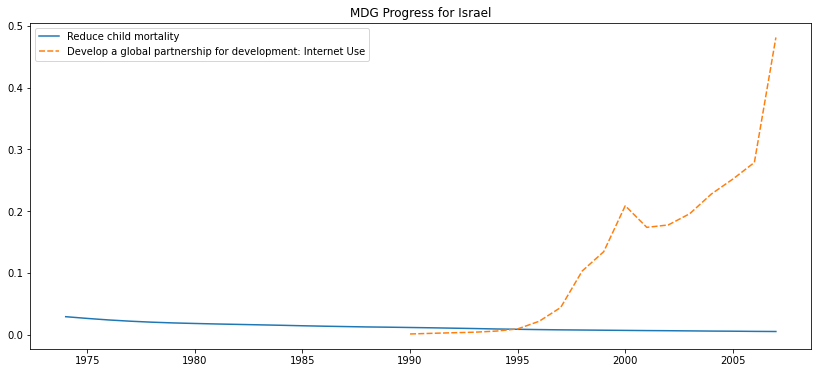

In [30]:
'''
---------------------------  PROGRESS TOWARDS MDGs ---------------------------------------

'''

targets, indicators = get_targets_and_indicators_by_country("Israel", data, mdgs)
country = targets['Country Name'].iloc[0]

years = [x for x in range(1972, 2008, 1)]

#Make series name the index for plot legend
targets = targets.set_index('Series Name')

#remove non numeric info
targets = targets.select_dtypes(exclude = ['object'])

#'1972 yr[1972]' ---> 1972
targets.columns = years

#flip so year is x-axis
targets = targets.transpose()

#get rid of nulls
targets = targets.mask(targets.isnull())

#plot config
plt.figure(figsize=(14, 6))
plt.title('MDG Progress for %s' % country)


line = sns.lineplot(data = targets)


In [31]:
import statistics 
#Get overlapping Indicators between countries
target_Z, indic_Z = get_targets_and_indicators_by_country("American Samoa", data, mdgs)
A_list = indicators['Series Name'].values.tolist()
Z_list = indic_Z['Series Name'].values.tolist()

overlap = set(A_list) & set(Z_list)


'''
--------------------  INFORMATION ABOUT INDICATORS --------------------

I will be using the value 934 as a baseline number of indicators (and 
therefore features for the models). 

'''

max = data.groupby('Country Name')['Series Name'].count().max()    #1255
min = data.groupby('Country Name')['Series Name'].count().min()    #13
avg = data.groupby('Country Name')['Series Name'].count().mean()   #913
mode = data.groupby('Country Name')['Series Name'].count().mode()  #887, 934, 1196, 1212


In [32]:
#Get all possible targets to be predicted
#x = data.loc[mdgs].groupby('Country Name')['Series Name'].count() == 6
target_data = data.loc[mdgs]
target_names = target_data['Series Name'].unique()
target_names.sort()


------------------------------------------------------------------------------------------------------------------


                                INDICATOR --> GOAL GENERALIZED MODEL
                                        
            x_input  -->  vec_indicators =  [ i1, i2 ... i(no_indicators_for_model)]
            y_output -->  vec_goals =       [ goal 1. . . goal 7]    

    This disregards the country from where the indicators are taken and seeks to find a more general relationship between the indicators and the goals for a specific year. Years are also ditched (after creating the DataFrames so that indicators map to the goal value for that year)
    

------------------------------------------------------------------------------------------------------------------


# Helper Functions

In [4]:
import datetime 

def convert_to_datetime(str):
   
    '''
    This function will be used in order to map the years in format '1972 [YR1972]' to a datetime object 
    '1972 - 01 - 01'
    '''
    
    str = str.split(' ')[0]
    str = datetime.datetime.strptime(str, '%Y')
    return str

-------
# Data Wrangling

SORTING DATA INTO SEPERATE INDICATOR AND GOAL DATAFRAMES

----

In [5]:
def get_indicators_for_model(indicator_threshold, indicator_dataframe):
    
    '''
    Sorts indicators by the amount of countries that have them, then picks all of the indicators until 
    it reaches one with indicator_threshold number of countries 
    
    args:
        indicator_threshold -- the minimum amount of countries with a given indicator
        indicator_dataframe -- dataframe to pull indicators from
        
    returns:
        most_common_indicators -- DataFrame with all indicators with count above indicator threshold
        
    '''
    
    #get(no_indicators_for_model) most common indicators in alphabetical order
    indicator_count = indicator_dataframe.groupby('Series Name')['Country Name'].count()
    indicator_count.sort_values(ascending = False)

    most_common_indicators = indicator_count[indicator_count >= indicator_threshold]
    most_common_indicators_list = most_common_indicators.index.sort_values().tolist()
    
    return most_common_indicators_list


In [6]:
def add_missing_indicators(feature_dataframe, indicators_list):
    
    '''
    Takes the feature dataframe, checks which indicators from the desired_indicators_list it doesn't have, 
    and adds Nan filled rows for each missing indicator

    args:
        feature_dataframe -- targets removed, indexed by [Country Name, Series Name]
        indicators_list -- returned from get_indicators_for_model

    '''

    #used for column names to populate dataframe for missing indicators
    years = feature_dataframe.columns

    #now add missing indicators and set values to nan for each country (NOTE! this can probably be done more efficiently)
    for country in countries:

        #get indicators for current country (as a DataFrame)
        current = feature_dataframe.loc[country]

        #determine which indicators are missing from current
        missing_indicators_list = set(indicators_list) - set(current.index.tolist())
        missing_count = len(missing_indicators_list)

        #create indices to match the multiindicies of the X_features multiindex df
        index_arrays = [np.array([str(country) for x in range(missing_count)]), np.array(list(missing_indicators_list))]

        #create a matrix of Nan values to be used for the missing indicator values
        nan_matrix = np.empty((missing_count, len(years)))
        nan_matrix[:] = np.nan

        #create a multiindex df for the missing indicators to append to the X_features df
        missing_indicators_midf = pd.DataFrame(nan_matrix, index = index_arrays, columns = years)
        feature_dataframe = feature_dataframe.append(missing_indicators_midf)

    #appending adds rows to end of df rather than end of rows with same index. Sorting fixes this
    feature_dataframe = feature_dataframe.sort_index()

    #Check to see that all countries have the same number of indicators
    checker = feature_dataframe.reset_index().groupby('Country Name')['Series Name'].count()
    assert(checker.iloc[0] > 0)
    assert(checker.sum() == checker.iloc[0] * len(checker))
    
    #reformat years so they are in datetime format
    reformatted_cols = feature_dataframe.columns.map(convert_to_datetime).tolist()
    feature_dataframe.columns = reformatted_cols

    #essentially swapping the years columns with the 'Series Name' index. In a sense, transposing
    feature_dataframe_stacked = feature_dataframe.stack(dropna = False)
    feature_dataframe = feature_dataframe_stacked.unstack(1)
    
    return feature_dataframe

----
# ALTERNATE IMPUTATION METHODS FOR STATISTICAL MODELS
----

These were developed in the early stages of the project. Might Still be useful, just not for current models.

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

#TODO: Fix logic for nan checking

def split_and_impute(features, targets, x_strategy, y_strategy, test_size):
    '''
    Vary impute methods and test_size to allow for testing models with multiple train and test sets
    
    args:
        features -- indicator dataframe (no index)
        targets  -- goal dataframe (no index)
        x_strategy -- how to impute indicators
        y_strategy -- how to impute goals 
        test_size -- for splitting data
    
    returns:
        X_train_imputed
        X_test_imputed
        y_train_imputed
        y_test_imputed
    '''
    
    t_check = True
    t1, t2, t3, t4 =  None, None, None, None 
    
    while(t_check):
        #split into sets, make sure the test split doesn't create any all-nan columns in subsets (making imputing impossible)
        resplit_not_successful = True
        X_train, X_test, y_train, y_test = None, None, None, None

        while(resplit_not_successful == True):
            X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = test_size, shuffle = True)
            sets_for_na_check = [X_train, X_test, y_train, y_test]   

            #false if all nan, meaning resplit is desired
            for i in sets_for_na_check:
                resplit_not_successful = resplit_not_successful and i.notna().any().any()

            #exit when resplit_not_successful is false 
            resplit_not_successful = resplit_not_successful != True

        #Add on to functionality later, for now x will always be simple imputer and y fillna()

        #Features
        if(x_strategy == 'simple_mean'):
            imputer_x = SimpleImputer(strategy = 'mean')

        elif(x_strategy == 'simple_median'):
            imputer_x = SimpleImputer(strategy = 'median')

        elif(x_strategy == 'simple_frequent'):
            imputer_x = SimpleImputer(strategy = 'most_frequent')

        X_train_imputed = pd.DataFrame(imputer_x.fit_transform(X_train), columns = X_train.columns)
        X_test_imputed  = pd.DataFrame(imputer_x.transform(X_test), columns = X_test.columns)

        #Targets
        if(y_strategy == 'fill_mean'):
            y_train_imputed = y_train.fillna(y_train.mean())
            y_test_imputed = y_test.fillna(y_test.mean())

        elif(y_strategy == 'fill_median'):
            y_train_imputed = y_train.fillna(y_train.median())
            y_test_imputed = y_test.fillna(y_test.median())

        elif(y_strategy == 'fill_mode'):
            y_train_imputed = y_train.fillna(y_train.mode())
            y_test_imputed = y_test.fillna(y_test.mode())


        #make sure no nan, if so call function again
        t1, t2, t3, t4 =  pd.isnull(X_train_imputed).any().any(), pd.isnull(X_test_imputed).any().any(), pd.isnull(y_train_imputed).any().any(), pd.isnull(y_test_imputed).any().any()
        t_check = t1 or t2 or t3 or t4
            
    print('t_check passed if false: ', t_check)
    return X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed, y_test, y_train


In [8]:
def knn_interpolate(filled_indicators_df, n_rows, n_knn_neighbors, d, knn_weights = None):
    '''
    Use KNN imputation to fill in a subset of the rows for each country. Then use interpolation to fill in
    the rest of the rows (so that they make sense as a progression over time)
    
    args:
        filled_indicators_df -- unimputed, indicator dataframe with missing indicators filled in
        n_rows -- how many vectors/rows for each country to use for KNN imp
        n_knn_neighbors -- how many neighbors to consider for knn imp
        knn_weights -- knn imputer paramter. 'uniform' by default, otherwise 'distance'
        
    returns:
        X_train_imputed
        X_test_imputed
        y_train_imputed
        y_test_imputed
    '''

    #check if passed dataframe has any columns with all nan values
    if(X_features_filled.isnull().all().any() == True):
        print("The dataframe contains columns with all nan values")
    
    
    #default knn_weights parameter
    if(knn_weights in (['uniform', 'distance']) == False):
        knn_weights == 'uniform'
        
    #1. Pick vectors for KNN imputation
    n_rows -= 4 #since I'm already adding the first and last years

    checker = True
    
    while(checker == True):
        
        n_rows += 3
            
        print("increased rows to: ", n_rows)
        
        grabbed = [years[i] for i in [0, -1]]

        for i in range(1, n_rows):
            grabbed.append(years[i*(36//n_rows)])

        #2. Pool together into new dataframe and use knn imputation
        df_for_knn_imputation = filled_indicators_df.loc[(slice(None), (grabbed)), :]
        
        #Check for all null columns (non imputable)
        if(df_for_knn_imputation.isnull().all().any() == True):
            print('----------- *! Warning !* -------------')
            print('Some columns have all nan values, fetching another few rows')
            print('total rows: ', df_for_knn_imputation.shape[0])
            d[n_rows] = df_for_knn_imputation.isnull().sum(axis = 0)
            
            #find which columns have all nan values
            #print("Count: ")
            #print(df_for_knn_imputation.isnull().sum(axis = 0))
            #nan_count = df_for_knn_imputation.isnull().sum(axis = 0)
            #print(nan_count[nan_count == ])
            #df_for_knn_imputation[df_for_knn_imputation.isnull().sum(axis = 0) == df_for_knn_imputation.shape[0]]

        else:
            checker = False
    
    print('Sucess: no columns have all nan values')
    print("Years: ", grabbed)
    
    imputer = KNNImputer(n_neighbors = n_knn_neighbors, weights = knn_weights)
    features_filled_knn = imputer.fit_transform(df_for_knn_imputation)

    #3. Return to orignal df
    
    #4. perform time interpolation

    return features_filled_knn

 ---------------------------


# IMPUTATION
Using TIME INTERPOLATION AND ITERATIVE IMP

-----------------------------

In [7]:
def interpolate_and_impute(dataframe, method = 'iterative', max_iter = 5, n_nearest_features = None):
    
    '''
    Use time interpolation and either iterative or knn interpolation to fill missing values in df
    
    args:
        dataframe -- df to be imputed
        method    -- iterative or knn (iter by default)
        max_iter  -- how many iterations of iterative imputation to perform
        n_nearest_features -- how many features to use for multivariate iter imp, by default use all of them
        
    returns:
        df_imputed
    '''
    
    #this comes from the original csv read into variable 'data'
    countries = data['Country Name'].unique()
    
    #by default, use all of the features for iterative imp
    if(n_nearest_features == None):
        n_nearest_features = int(dataframe.shape[1])

    #This splits the unimputed df into seperate DFs by country, then interpolates them
    forward_interpolated_dict = {"X_features_filled_unimputed": dataframe}   #first element is unimputed df
    for country in countries:
        forward_interpolated_dict[country] = dataframe.loc[country].interpolate(method = 'time', axis = 0, limit_direction = 'both')

    #make sure country_col is correct length
    range_amount = len(forward_interpolated_dict['Afghanistan'].index)

    #append country name column for later regrouping by country (Afghanistan outside to have a starting df to concat to)
    country_col = ['Afghanistan' for x in range(range_amount)]
    interpolated_indicators_restitched = forward_interpolated_dict['Afghanistan']
    interpolated_indicators_restitched['Country Name'] = country_col
    
    #TODO WArning: Make sure concat isn't creating any new NAN values 1    1  nan  nan
    #                                                                nan  nan  1    1
    

    #add country name column foreach country, then concat to restitched df
    for item in forward_interpolated_dict:
        if(item != 'Afghanistan' and item != 'X_features_filled_unimputed'):
            to_be_concat = forward_interpolated_dict[item]
            to_be_concat['Country Name'] = [item for x in range(range_amount)]
            interpolated_indicators_restitched = pd.concat([interpolated_indicators_restitched, to_be_concat], axis = 0)

    #Recreate the original multiindex dataframe (ie X_features_filled) with interpolated values 
    index = interpolated_indicators_restitched.index
    country_col_all = interpolated_indicators_restitched['Country Name']
    interpolated_indicators_restitched.drop(columns = 'Country Name', inplace = True)
     
    if(method == 'iterative'):
        imputer = IterativeImputer(max_iter = max_iter, n_nearest_features = n_nearest_features)
        
    elif (method == 'knn'):
        imputer = KNNImputer()
    
    imputer.fit(interpolated_indicators_restitched)
    dataframe_fully_interpd = imputer.transform(interpolated_indicators_restitched)
    dataframe_fully_interpd = pd.DataFrame(dataframe_fully_interpd, columns = dataframe.columns, index = index)
    dataframe_fully_interpd['Country Name'] = country_col_all
    dataframe_fully_interpd = dataframe_fully_interpd.set_index(['Country Name', index])

    return dataframe_fully_interpd

In [8]:
def impute_test_val(dataframe, method = 'iterative', filler = 0):
    '''
    Use either iterative or knn interpolation to fill missing values in test or validation df
    
    args:
        dataframe -- df to be imputed
        method    -- iterative or knn (iter by default)
        filler    -- replace all-nan columns with this value
        
        TODO: maybe find a bettersolution to the filler value
        
    returns:
        df_imputed
    '''
    
    #find all-nan columns
    all_nan_cols_bool = dataframe.isnull().all().tolist()
    all_nan_cols = list(dataframe.columns[all_nan_cols_bool])
    
    #replace these columns with filler values
    dataframe[all_nan_cols] = dataframe[all_nan_cols].fillna(value = filler)
    
    #and now impute
    
    if (method == 'iterative'):
        imputer = IterativeImputer()
    
    elif(method == 'knn'):
        imputer = KNNImputer()
    
    imputer.fit(dataframe)
    imputed_dataframe = imputer.transform(dataframe)
    
    return pd.DataFrame(imputed_dataframe, columns = dataframe.columns, index = dataframe.index)
    

----

# MODEL EVALUATION HELPER FUNCTIONS

----

In [124]:
def compute_unimputed_cost(y_unimputed, y_hat, y_test_imputed, error_type):
    '''
    Get boolean array of non-nan values from the unimputed target df (y_unimputed), access corresponding 
    elements from y_hat and y_test, and compare these two df's, giving the actual performance
    
    args:
        y_unimputed -- target dataframe before imputing
        y_hat -- predicted target array 
        y_test_imputed -- from train test split (imputed)
        error_type -- mean squared, absolute, etc
    
    returns:
        cost 
    '''
    
    #This is for naiive forecsting since y_hat_naiive won't be a numpy array, but y_hat from models will be
    if(type(y_hat) != np.ndarray):
        y_hat = y_hat.values
    
    bool_array = y_unimputed.isna()
    y_hat_filtered = y_hat[bool_array]
    y_test_filtered = y_test_imputed.values[bool_array]
    
    assert(y_hat_filtered.shape == y_test_filtered.shape)
    
    cost = 0
    
    if(error_type == 'absolute'):
        cost = mean_absolute_error(y_hat_filtered, y_test_filtered)
    
    elif(error_type == 'squared'):
        cost = mean_squared_error(y_hat_filtered, y_test_filtered)
    
    return cost, y_hat_filtered, y_test_filtered


----
# PIPELINE
----

In [10]:
'''-----------------------------------------------------------------------------------------------------------

                        Step 0: A - Get targets and indicators in seperate dataframes
                                            and format indices

                                B - Fill target dataframe with missing targets for
                                                each country

-----------------------------------------------------------------------------------------------------------'''

#A

#Pull data from original csv and seperate mdgs from indicators
mdgs = submission.index
mdgs_for_i2g_model = data_original.loc[mdgs]

target_names = mdgs_for_i2g_model['Series Name'].unique()
indicators_for_i2g_model = data_original[data_original['Series Name'].isin(target_names) == False]
indicators_for_i2g_model.sort_values(by = ['Country Name', 'Series Name'])

#Get data_original into proper DataFrame format for i2g 

#Create a multi index DataFrame for legibility
X_features = indicators_for_i2g_model.set_index(['Country Name', 'Series Name'])
X_features = X_features.drop(['Series Code'], axis = 1)
X_features = X_features.sort_index()

#make sure there is no overlap between mdgs and indicators
assert(set(X_features.index.get_level_values(1)) & set(mdgs_for_i2g_model['Series Name'].values) == set())


#B

#create a goals df
targets = mdgs_for_i2g_model.set_index(['Country Name', 'Series Name'])
targets = targets.drop('Series Code', axis = 1)

#!NOTE! - targets does not contain all countries as the submission does not require goal predictions for every country
# try adding empties for missing countries, then try again and disregard missing countries

#214 countries in the dataset
countries = data['Country Name'].unique()

countries_in_targets = targets.index.unique()
missing_countries = set(countries) - set(countries_in_targets)

years = X_features.columns

nan_row = np.empty((1, len(years)))
nan_row[:] = np.nan

#for missing countries
not_found = False

#add missing targets to each country (this is similar enough to what I did for X_features missing indicators. maybe this can be a function?
for country in countries:
    
    #get current country targets (this might fail if country isn't in mdgs)
    try: 
        current = targets.loc[country]
    except:
        not_found = True

    #which targets are missing?
    if(not_found == False):
        missing_targets = set(target_names) - set(current.index.tolist())
    
    #country wasn't in mdgs, so its missing all targets
    else:
        missing_targets = target_names
        
    #create nan dataframe for missing targets and append to targets df
    missing_targets_indices = [np.array([country for x in range(len(missing_targets))]), np.array(list(missing_targets))]

    nan_matrix = np.empty((len(missing_targets), len(years)))
    nan_matrix[:] = np.nan

    missing_targets_midf = pd.DataFrame(nan_matrix, index = missing_targets_indices, columns = years)
    targets = targets.append(missing_targets_midf)
    not_found = False
    
#fix append issue (so added vectors appear with grouped country)
targets = targets.sort_index()

#reformat years so they are in datetime format
reformatted_cols = targets.columns.map(convert_to_datetime).tolist()
targets.columns = reformatted_cols

#essentially swapping the years columns with the 'Series Name' index. In a sense, transposing
targets_stacked = targets.stack(dropna = False)
targets = targets_stacked.unstack(1)

In [12]:
'''-----------------------------------------------------------------------------------------------------------

                        Step 1: get only indicators from each country that are in 
                                        the most_common_indicator_list

-----------------------------------------------------------------------------------------------------------'''

most_common_indicators_list = get_indicators_for_model(200, indicators_for_i2g_model)
X_features_most_common = X_features[X_features.index.isin(most_common_indicators_list, level=1)]

print('Number of indicators: %d' % len(most_common_indicators_list))

Number of indicators: 80


In [13]:
'''-----------------------------------------------------------------------------------------------------------

                        Step 2: fill indicator dataframe with missing indicators
                                            for each country

-----------------------------------------------------------------------------------------------------------'''

X_features_filled = add_missing_indicators(X_features_most_common, most_common_indicators_list)

In [14]:
'''-----------------------------------------------------------------------------------------------------------

                             Step 2.01: Normalize/Standardize the features

-----------------------------------------------------------------------------------------------------------'''

columns = X_features_filled.columns
index = X_features_filled.index

#Normalization
scaler = MinMaxScaler()
X_features_filled = scaler.fit_transform(X_features_filled)

#Standardization
#scaler = StandardScaler()
#X_features_filled = scaler.fit_transform(X_features_filled)

X_features_filled = pd.DataFrame(X_features_filled, columns = columns, index = index)


In [15]:
'''-----------------------------------------------------------------------------------------------------------

                        Step 2.1: Pearson Correlation for Feature Selection

-----------------------------------------------------------------------------------------------------------'''

#This is calculated here in order to avoid leakage
train_indices = X_features_filled.loc['Afghanistan'].index[0:34].tolist()

relevance_dict = {}
correlation_threshold = 0.75
features_and_targets = pd.concat([X_features_filled.loc[pd.IndexSlice[:, train_indices], :], targets.loc[pd.IndexSlice[:, train_indices], :]], axis = 1, sort = False)

#Correlation to targets
cor = features_and_targets.corr()

#add each goal's correlated features to the relevance_dict
for i in range(7):    
    cor_target = abs(cor[target_names[i]])
    relevant = cor_target[cor_target >= correlation_threshold]
    relevance_dict[target_names[i]] = relevant

#TODO: Caution, Malaria Goal has 1.0 correlation with indicators that it maybe shouldn't 

#create a set of relevant features from each of the targets' correlation matrices
relevant_features = set([])

for goal in relevance_dict.keys():
    #print("\n----------  Relevant Features for: ", goal + ' -------------\n')
    #print(relevance_dict[goal])
    relevant_features.update(relevance_dict[goal].index.tolist())

#remove targets from relevant features
relevant_features = relevant_features - set(target_names)

print('%d relevant features chosen' % len(relevant_features))

71 relevant features chosen


In [152]:
features_and_targets

Series Name              Adjusted savings: consumption of fixed capital (current US$)  \
Country Name                                                                            
Afghanistan  1972-01-01                                                NaN              
             1973-01-01                                                NaN              
             1974-01-01                                                NaN              
             1975-01-01                                                NaN              
             1976-01-01                                                NaN              
...                                                                    ...              
Zimbabwe     2001-01-01                                           0.000405              
             2002-01-01                                           0.000378              
             2003-01-01                                           0.000339              
             2004-01-01                                           0.000343              
             2005-01-01                                           0.000329              

Series Name              Adjusted savings: energy depletion (% of GNI)  \
Country Name                                                             
Afghanistan  1972-01-01                                       0.013971   
             1973-01-01                                       0.015293   
             1974-01-01                                       0.030615   
             1975-01-01                                       0.029049   
             1976-01-01                                       0.025262   
...                                                                ...   
Zimbabwe     2001-01-01                                       0.003995   
             2002-01-01                                       0.001098   
             2003-01-01                                       0.001823   
             2004-01-01                                       0.011294   
             2005-01-01                                       0.008375   

Series Name              Adjusted savings: energy depletion (current US$)  \
Country Name                                                                
Afghanistan  1972-01-01                                          0.000104   
             1973-01-01                                          0.000124   
             1974-01-01                                          0.000309   
             1975-01-01                                          0.000322   
             1976-01-01                                          0.000302   
...                                                                   ...   
Zimbabwe     2001-01-01                                          0.000118   
             2002-01-01                                          0.000031   
             2003-01-01                                          0.000046   
             2004-01-01                                          0.000286   
             2005-01-01                                          0.000210   

Series Name              Adjusted savings: mineral depletion (% of GNI)  \
Country Name                                                              
Afghanistan  1972-01-01                                        0.000000   
             1973-01-01                                        0.000000   
             1974-01-01                                        0.000000   
             1975-01-01                                        0.000000   
             1976-01-01                                        0.000000   
...                                                                 ...   
Zimbabwe     2001-01-01                                        0.006976   
             2002-01-01                                        0.014633   
             2003-01-01                                        0.035144   
             2004-01-01                             

In [16]:
'''-----------------------------------------------------------------------------------------------------------

                             Step 2.2: Training/Val/Test Split

-----------------------------------------------------------------------------------------------------------'''
#TODO Target leakage if Val/Test set used in correlation?

#update X_features_filled with relevant features
X_features_filled_relevant = X_features_filled[relevant_features]

#training set
train_indices_strings = list(map(lambda x: str(train_indices[x]), range(len(train_indices))))
X_train = X_features_filled_relevant.loc[pd.IndexSlice[:, train_indices], :]
y_train = targets.loc[pd.IndexSlice[:, train_indices], :]

#val set
valid_year = '2006-01-01'
X_valid = X_features_filled_relevant.loc[pd.IndexSlice[:, [valid_year]], :]
y_valid = targets.loc[pd.IndexSlice[:, [valid_year]], :]

#test set
test_year = '2007-01-01'
X_test = X_features_filled_relevant.loc[pd.IndexSlice[:, [test_year]], :]
y_test = targets.loc[pd.IndexSlice[:, [test_year]], :]

In [17]:
'''-----------------------------------------------------------------------------------------------------------

                                Step 2.3: IMPUTATION OF SETS

-----------------------------------------------------------------------------------------------------------'''

#Iterative Imputer parameters
y_n_iter = 10
x_n_iter = 3

print('Imputing X_train . . .')
X_train_imputed = interpolate_and_impute(X_train, max_iter = x_n_iter)

print('X_train imputation successful! \n Imputing y_train . . .')
y_train_imputed = interpolate_and_impute(y_train, max_iter = y_n_iter)

print('Training Set Imputation Complete!')

#TODO: For now, run iterative imputer on test and val sets until they converge since they are pretty small

print('Imputing Validation and Test Sets . . .')
X_val_imputed, X_test_imputed = impute_test_val(X_valid), impute_test_val(X_test)
y_val_imputed, y_test_imputed = impute_test_val(y_valid), impute_test_val(y_test)

#Make sure imputation was successful
assert(y_train_imputed.isnull().any().any() == False)
assert(X_train_imputed.isnull().any().any() == False)
assert(X_val_imputed.isnull().any().any() == False)
assert(X_test_imputed.isnull().any().any() == False)
assert(y_val_imputed.isnull().any().any() == False)
assert(y_test_imputed.isnull().any().any() == False)

print('Validation and Test Sets Imputed Successfully!')

Imputing X_train . . .


C:\Users\Yousef\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


X_train imputation successful! 
 Imputing y_train . . .


C:\Users\Yousef\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Training Set Imputation Complete!
Imputing Validation and Test Sets . . .


C:\Users\Yousef\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Yousef\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
C:\Users\Yousef\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\Yousef\anaconda3\lib\site-packages\sk

Validation and Test Sets Imputed Successfully!


C:\Users\Yousef\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


---------------------
# TABLEAU

EXPORT DF TO EXCEL FOR TABLEAU DATa VIZ
                                
----

In [ ]:
X_reset = X_features_filled.reset_index()
X_reset = X_reset.set_index('Country Name')
X_reset.rename(columns = {'level_1':'Year'}, inplace = True)
X_reset.to_excel(r'C:\Users\Yousef\Desktop\export_df_3.xlsx')

------

# Modelling 

In this section I will develop models to forecast the UNMDGS (Targets) for each country. I will Use the years 2006 and 2007 for training and validation in order to fine tune my models, but the aim of the project is to forecast values for 2008 and 2012.

---

# Baseline: 
Naive Forecasting: Use Last Year's Target Values

Series Name
Achieve universal primary education                           0.945748
Combat HIV/AIDS                                               0.012538
Combat malaria and other diseases                             0.025115
Develop a global partnership for development: Internet Use    0.060439
Ensure environmental sustainability                           0.962000
Improve maternal health                                       0.000285
Reduce child mortality                                        0.022200
Name: (Albania, 2005-01-01 00:00:00), dtype: float64

In [93]:
#X_features_filled_relevant.loc[pd.IndexSlice[:, train_indices], :]
y_hat_2006_naiive = y_train_imputed.loc[pd.IndexSlice[:, '2005'], :]
mse_2006_naiive = mean_squared_error(y_hat_2006_naiive.values, y_val_imputed.values)
mse_2006_naiive_unimputed, _, _ = compute_unimputed_cost(y_valid, y_hat_2006_naiive, y_val_imputed, 'squared')

y_hat_2007_naiive = y_val_imputed
mse_2007_naiive = mean_squared_error(y_hat_2007_naiive.values, y_test_imputed.values)
mse_2007_naiive_unimputed, _, _ = compute_unimputed_cost(y_test, y_hat_2007_naiive, y_test_imputed, 'squared')

print('\n----------------------------------------------------\n')
print('Baseline MSE for 2006 Target Predictions: %f \n Baseline unimputed MSE for 2006 Target Prediction %f' %(mse_2006_naiive, mse_2006_naiive_unimputed))
print('\nBaseline MSE for 2007 Target Predictions: %f \n Baseline unimputed MSE for 2007 Target Prediction %f' % (mse_2007_naiive, mse_2007_naiive_unimputed))
print('\n----------------------------------------------------\n')


----------------------------------------------------

Baseline MSE for 2006 Target Predictions: 0.001493 
 Baseline unimputed MSE for 2006 Target Prediction 0.003208

Baseline MSE for 2007 Target Predictions: 0.000919 
 Baseline unimputed MSE for 2007 Target Prediction 0.000735

----------------------------------------------------



Idea: Use models for forecsting the indicators for the following year, then
    feed all of them into one I2G model

# LSTM (On Hold, CNN is current priority)

In [ ]:
model = Sequential()
model.add(Dense(20, input_shape = (X_fcc.shape[1], 1)))
model.add(Dense(7))

In [68]:
#reshape inputs to 3D [samples, timestamps, features] = [no countries, years in set (34 for training), relevant features]
#X_train_imputed_reshaped = X_train_imputed.values.reshape((len(countries), len(train_indices), X_train_imputed.shape[1]))
#X_val_imputed_reshaped = X_train_imputed.values.reshape((len(countries), 1, X_train_imputed.shape[1]))
#X_test_imputed_reshaped = X_train_imputed.values.reshape((len(countries), 1, X_train_imputed.shape[1]))

#Network Archtecture
model = Sequential()
model.add(LSTM(50))#, input_shape = (X_train_imputed_reshaped[1], X_train_imputed_reshaped[2]))
model.add(Dense(7))
model.compile(loss = 'mae', optimizer = 'adam')

# METHOD: 1D CNN

# A: Multivariate Forecasting -> Goal Prediction
This model acts as a baseline for the next CNN models. It takes 34-year samples for each countrys indicators, and predicts the values for the indicators the following year, then predicts the UNMDGs for that year

In [243]:
model.name = "Forecast Goals From Previous Years' Indicators"
model.name
model.summary()

Model: "Forecast Goals From Previous Years' Indicators"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 34, 71)            22223     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 8, 71)             0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 568)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 780)               443820    
_________________________________________________________________
dense_50 (Dense)             (None, 78)                60918     
_________________________________________________________________
dense_51 (Dense)             (None, 78)                6162      
_________________________________________________________________
dense_52 (Dense)    

In [338]:
CNN_hyperparam_to_loss_dict = {'params':('filters', 'ksize', 'psize', 'epochs', 'd1out')}

In [434]:
#for reproducible results
from numpy.random import seed
seed(1)

tf.random.set_seed(2)

#Hyperparams
n_filters = int(X_train_with_goals.shape[1])
kernel_size = 7
pool_size = 3
epochs = 120

#input dims
n_samples = 214
n_steps = X_train_imputed.loc['Afghanistan'].shape[0]
#n_features = X_train_imputed.shape[1]
n_features = X_train_with_goals.shape[1]

dense_1_output = int(n_features * 10) #For handling vector from convolution
dense_2_output = int(n_features)  #Forecast next years indicators 
dense_3_output = int(n_features)  #Hidden Layer

#predicting all goals with same model: 7
dense_4_output = 7

#shape of inputs(no_countries x n_years x n_relevant_features)
x_shape = (n_samples, n_steps, n_features)

#shape of outputs(no_countries x no_goals)
y_shape = (n_samples, 7)

#for tuning
h_params = [n_filters, kernel_size, pool_size, epochs, dense_1_output]

#reshape data
#X_train_imputed_reshaped_CNN = np.array(X_train_imputed.values).reshape((n_samples, n_steps, n_features))
y_train_imputed_reshaped_CNN = np.array(y_val_imputed.values).reshape((n_samples, 7))

#8/8/20 idea: include goals as features
X_train_with_goals = pd.concat([X_train_imputed, y_train_imputed], axis = 1)
y_train_with_goals = pd.concat([X_val_imputed, y_val_imputed], axis = 1)

X_train_imputed_reshaped_CNN = np.array(X_train_with_goals.values).reshape((n_samples, n_steps, n_features))
#y_train_imputed_reshaped_CNN = np.array(y_train_with_goals.values).reshape((n_samples, n_features))

#add a callback to stop training when no improvement in loss
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15)

#CNN model architecture
model = Sequential()
model.add(Conv1D(padding = 'same', filters = n_filters, kernel_size = kernel_size, activation = 'relu', 
                input_shape = (n_steps, n_features)))
model.add(MaxPooling1D(pool_size = pool_size))
model.add(Flatten())
model.add(Dense(dense_1_output, activation = 'relu'))
model.add(Dense(dense_2_output, activation = 'relu'))
model.add(Dense(dense_3_output, activation = 'sigmoid'))
model.add(Dense(dense_4_output))
model.compile(optimizer = 'adam', loss = 'mse')

history = model.fit(X_train_imputed_reshaped_CNN, y_train_imputed_reshaped_CNN, epochs = epochs, callbacks = [early_stop], verbose = False)

#store results
listhist = np.array(history.history['loss'])
CNN_hyperparam_to_loss_dict[listhist[-1]] = h_params

In [435]:
CNN_hyperparam_to_loss_dict

{'params': ('filters', 'ksize', 'psize', 'epochs', 'd1out'),
 0.00010645977522259596: [71, 4, 4, 120, 780],
 0.0017688923056246102: [71, 4, 4, 20, 780],
 0.0018683101091899466: [71, 4, 4, 20, 780],
 0.005416893017278096: [71, 4, 4, 20, 780],
 0.002077976874920113: [71, 4, 4, 20, 780],
 0.0021870021869332713: [78, 4, 4, 20, 780],
 0.0020212127901091475: [156, 4, 4, 20, 780],
 0.0016693142797606431: [156, 6, 4, 20, 780],
 0.0017621701476642879: [156, 7, 4, 20, 780],
 0.0025034226155100023: [156, 7, 7, 20, 780],
 0.001648060300726896: [156, 7, 3, 20, 780],
 0.0021598441428374326: [78, 7, 3, 20, 780],
 0.0020548045530775997: [234, 7, 3, 20, 780],
 0.0014651812206100776: [156, 7, 3, 20, 780],
 0.0014993841476982164: [156, 7, 3, 20, 780],
 0.001950917174717603: [156, 7, 3, 20, 780],
 0.0017856983380897023: [156, 7, 3, 20, 780],
 0.0014858862306818227: [156, 7, 3, 20, 780],
 0.00010724324578251777: [156, 7, 3, 120, 780],
 6.795012470711213e-05: [78, 7, 3, 120, 780],
 5.2411585716284796e-05: [

Stopped after 120 / 120 iterations


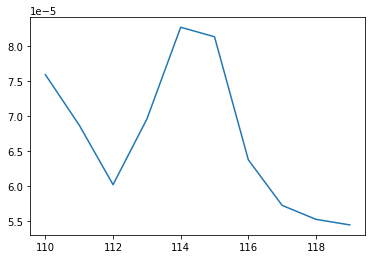

In [436]:
iters = len(history.history['loss'])
x = [i for i in range(len(history.history['loss']))]
print("Stopped after %i / %i iterations" % (iters, epochs))

window = iters - 10
plt.plot(x[window:], listhist[window:])

In [437]:
#Create a validation set and predict for 2007

#Get a training dataframe for years 1973-2005
predict_indices = X_features_filled.loc['Afghanistan'].index[1:34].tolist()
X_indicators = X_train_imputed.loc[pd.IndexSlice[:, predict_indices], :]
X_targets = y_train_imputed.loc[pd.IndexSlice[:, predict_indices], :]
X_val_CNN = pd.concat([X_indicators, X_targets], axis = 1)
assert(X_val_CNN.isna().any().any() == False)

#Get original validation set, badly named, and append goals to indicators
X_2006 = pd.concat([X_val_imputed, y_val_imputed], axis = 1)
assert(X_2006.isna().any().any() == False)

#append 2006 to validation set
X_val_CNN = pd.concat([X_val_CNN, X_2006], axis = 0)
X_val_CNN = X_val_CNN.sort_index()
assert(X_val_CNN.isna().any().any() == False)

#reshape and make prediction
x_val_CNN_reshaped = np.array(X_val_CNN.values).reshape(x_shape)
y_hat = model.predict(x_val_CNN_reshaped)

mse_test = mean_squared_error(y_hat, y_test_imputed)
unim_cost, y_hat_filtered, y_test_filt = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')

print('MSE for Test Set: ', mse_test)
print('Unimputed MSE for Test Set: ', unim_cost)

#Compare to prediction on training data
y_hat_train = model.predict(X_train_imputed_reshaped_CNN)
mse_train = mean_squared_error(y_hat_train, y_val_imputed)

unim_cost_train, y_hat_filtered_train, y_test_filt_train = compute_unimputed_cost(y_valid, y_hat_train, y_val_imputed, 'squared')

print('\nMSE for Train Set: ', mse_train)
print('Unimputed MSE for Train Set: ', unim_cost_train)

MSE for Test Set:  0.0008846143006179362
Unimputed MSE for Test Set:  0.0007853896729013954

MSE for Train Set:  5.855493902801191e-05
Unimputed MSE for Train Set:  4.926222934487768e-05


----------------------------------------------------

Baseline MSE for 2006 Target Predictions: 0.001493 
 Baseline unimputed MSE for 2006 Target Prediction 0.003208

Baseline MSE for 2007 Target Predictions: 0.000919 
 Baseline unimputed MSE for 2007 Target Prediction 0.000735

----------------------------------------------------

# B: Multiple Output 

In [ ]:
Each feature (indicator)

-----
------
----
# Statistical Analysis From Early Stages 

These models were built to map indicators to goals without making use of the nature of time series data. They are not useless, though currently not being used. I have future plans. . .

In [ ]:
'''------------------------------------------------------------------------------------------------------------------------

                                    Step 5.1: MultiOutput Regression

-------------------------------------------------------------------------------------------------------------------------'''

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Get a list of multioutput regressors
mo_regressors = [("KNeighbors", KNeighborsRegressor()), ("Linear Regression", LinearRegression()), ("Random Forest", RandomForestRegressor(n_estimators = 25))]
prediction_dict = {}
cost_dict = {}

print("Starting MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    model[1].fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = model[1].predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)

In [ ]:
#Print results for multioutput models
print("Sorted in ascending order: \n")
for cost in sorted(cost_dict, key=cost_dict.get, reverse=False):
    print(cost, cost_dict[cost])

In [ ]:
Random Forest_unimputed_cost_sq 0.0001655662543860639
Random Forest_unimputed_cost_abs 0.0001655662543860639
Random Forest_imputed_cost_sq 0.0003427480761347908
Random Forest_imputed_cost_abs 0.0003427480761347908
KNeighbors_unimputed_cost_sq 0.0005737431992566561
KNeighbors_unimputed_cost_abs 0.0005737431992566561
Linear Regression_unimputed_cost_sq 0.0008768644934505436
Linear Regression_unimputed_cost_abs 0.0008768644934505436
Linear Regression_imputed_cost_sq 0.001335331308048639
Linear Regression_imputed_cost_abs 0.001335331308048639
KNeighbors_imputed_cost_sq 0.001883435669439014
KNeighbors_imputed_cost_abs 0.001883435669439014

In [ ]:
'''------------------------------------------------------------------------------------------------------------------------

                                Step 5.2: Wrapper MultiOutput Regression

-------------------------------------------------------------------------------------------------------------------------'''

from sklearn.multioutput import MultiOutputRegressor
#from sklearn.svm import LinearSVM

#Get a list of multioutput regressors
mo_regressors = [("KNeighbors", KNeighborsRegressor()), ("Linear Regression", LinearRegression()), ("Random Forest 5", RandomForestRegressor(n_estimators = 5))]
prediction_dict = {}
cost_dict = {}

print("Starting Wrapper MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    wrapper = MultiOutputRegressor(model[1])
    wrapper.fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = wrapper.predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)




In [ ]:
#Print results for multioutput models
print("Sorted in ascending order: \n")
for cost in sorted(cost_dict, key=cost_dict.get, reverse=False):
    print(cost, cost_dict[cost])

In [ ]:
#Random Forest with wrapper seems to work the best so far, lets see the results

#Get a list of multioutput regressors
mo_regressors = [("5", RandomForestRegressor(n_estimators = 5)), ("40", RandomForestRegressor(n_estimators = 20)), ("50", RandomForestRegressor(n_estimators = 30))]
prediction_dict = {}
cost_dict_wrapper_rf = {}

print("Starting Wrapper MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    wrapper = MultiOutputRegressor(model[1])
    wrapper.fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = wrapper.predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict_wrapper_rf[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict_wrapper_rf[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict_wrapper_rf[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict_wrapper_rf[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)

In [ ]:
print("Costs for Wrapped RF chains in ascending order: \n")
for cost in sorted(cost_dict_wrapper_rf, key=cost_dict_wrapper_rf.get, reverse=False):
    print(cost, cost_dict_wrapper_rf[cost])

In [ ]:
#Print results for multioutput models (only RFs)
print("Sorted in ascending order: \n")
for cost in sorted(cost_dict, key=cost_dict.get, reverse=False):
    print(cost, cost_dict[cost])

In [ ]:
'''------------------------------------------------------------------------------------------------------------------------

                                    Step 5.1: MultiOutput Regression, RandForests

-------------------------------------------------------------------------------------------------------------------------'''

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Get a list of multioutput regressors
mo_regressors = [("RF - 5", RandomForestRegressor(n_estimators = 5)), ("RF - 10", RandomForestRegressor(n_estimators = 10)), ("RF - 25", RandomForestRegressor(n_estimators = 25)), ("RF - 50", RandomForestRegressor(n_estimators = 50))]
prediction_dict = {}
cost_dict = {}

print("Starting MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    model[1].fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = model[1].predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)

In [ ]:
print("Sorted in ascending order: \n")
for cost in sorted(cost_dict, key=cost_dict.get, reverse=False):
    print(cost, cost_dict[cost])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

unimp_cost_sq, y_hat_filt, y_test_filt = compute_unimputed_cost(y_test, y_hat_knr, y_test_imputed, 'squared')
unimp_cost_abs, y_hat_filt, y_test_filt = compute_unimputed_cost(y_test, y_hat_knr, y_test_imputed, 'absolute')

imp_cost_sq = mean_squared_error(y_hat_knr, y_test_imputed)
imp_cost_abs = mean_absolute_error(y_hat_knr, y_test_imputed)

print('Imputed_abs: %f\nImputed_sq: %f\nUnimputed_abs: %f \nUnimputed_sq: %f' % (imp_cost_abs, imp_cost_sq, unimp_cost_abs, unimp_cost_sq))

y_hat_knr_train = my_model.predict(X_train_imputed)

train_unimp_cost_sq, y_hat_filt, y_test_filt = compute_unimputed_cost(y_train, y_hat_knr_train, y_train_imputed, 'squared')
train_unimp_cost_abs, y_hat_filt, y_test_filt = compute_unimputed_cost(y_train, y_hat_knr_train, y_train_imputed, 'absolute')

train_imp_cost_sq = mean_squared_error(y_hat_knr_train, y_train_imputed)
train_imp_cost_abs = mean_absolute_error(y_hat_knr_train, y_train_imputed)

print('Training:')
print('Imputed_abs: %f\nImputed_sq: %f\nUnimputed_abs: %f \nUnimputed_sq: %f' % (train_imp_cost_abs, train_imp_cost_sq, train_unimp_cost_abs, train_unimp_cost_sq))


In [ ]:
'''-----------------------------------------------------------

    Step 5: Create model, fit, and predict 
    
                    CROSS VALIDATION

--------------------------------------------------------------'''

from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

targets_y = targets_y.fillna(targets_y.mean())
features_X = features_X.fillna(features_X.mean())

kfold = model_selection.KFold(n_splits=5)
wrapper = MultiOutputRegressor(RandomForestRegressor(n_estimators = 5))
scoring = 'r2'
results = model_selection.cross_val_score(wrapper, features_X, targets_y, cv=kfold, scoring=scoring)

#print("R^2: %.3f (%.3f)") % (results.mean(), results.std())

In [ ]:
print(results)

In [ ]:
y_hat[0:4]

In [ ]:
#Shapley Values : Determine which indicators of all of them have the greatest impact on determingin the targets, then build a model based
#    on thse specific indicators 

In [ ]:
Idea: run seperate models for each target. As for projecting into the future, find a way to accurately interpolate a countries indicator values in the years 2008 and 2012, after deciding which are the best indicators to use (both shapley and threshold) and then create an indicator vector accordingly and predict its target value accordingly

In [ ]:
#Random Forest with wrapper seems to work the best so far, lets see the results

#Get a list of multioutput regressors
mo_regressors = [("5.1", RandomForestRegressor(n_estimators = 5)), ("5.2", RandomForestRegressor(n_estimators = 5)), ("5.3", RandomForestRegressor(n_estimators = 5))]
prediction_dict = {}
cost_dict_wrapper_rf = {}

print("Starting Wrapper MultiOutput Regression with multiple models . . .")

#Fit each model to imputed training data, then predict
for model in mo_regressors:
    wrapper = MultiOutputRegressor(model[1])
    wrapper.fit(X_train_imputed, y_train_imputed)
    print("Fit " + model[0])
    
    prediction_dict[model[0]] = wrapper.predict(X_test_imputed)
    print("Predictions made with " + model[0])
    
print("Calculating errors . . . ")
#5 - calculate error for each model 
for prediction in prediction_dict:
    
    y_hat = prediction_dict[prediction]
    
    unimp_cost_sq, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
    unimp_cost_abs, _, _ = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')
    imp_cost_sq = mean_squared_error(y_hat, y_test_imputed)
    imp_cost_abs = mean_absolute_error(y_hat, y_test_imputed)
    
    cost_dict_wrapper_rf[prediction + "_unimputed_cost_sq"] = unimp_cost_sq
    cost_dict_wrapper_rf[prediction + "_unimputed_cost_abs"] = unimp_cost_sq
    cost_dict_wrapper_rf[prediction + "_imputed_cost_sq"] = imp_cost_sq
    cost_dict_wrapper_rf[prediction + "_imputed_cost_abs"] = imp_cost_sq
    
    print("Error analysis for %s complete" % prediction)

In [ ]:
print("Costs for Wrapped RF chains in ascending order: \n")
for cost in sorted(cost_dict_wrapper_rf, key=cost_dict_wrapper_rf.get, reverse=False):
    print(cost, cost_dict_wrapper_rf[cost])

In [ ]:
'''------------------------------------------------------------------------------------------------------------------------

                                    Step 5.3: Fully Connected Neural Network (Keras)
                                    
                              *******UNDER CONSTRUcTION -- COME BACK LATER******

-------------------------------------------------------------------------------------------------------------------------'''

from keras.models import Sequential
from keras.layers import Dense

input_dim = 468
output_dim = 7

model = Sequential()
model.add(Dense(230, input_dim = input_dim, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(output_dim))
model.compile(loss = 'mse', optimizer = 'adam')

model.summary()

In [ ]:
model.fit(X_train_imputed.to_numpy(), y_train_imputed.to_numpy(), epochs = 50)

In [ ]:
'''------------------------------------------------------------------------------------------------------------------------

                        FEATURE IMPORTANCE -- Attempt using Random Forest with Wrapper 
                                    
-------------------------------------------------------------------------------------------------------------------------'''
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

model = RandomForestRegressor(n_estimators = 5)
wrapper = MultiOutputRegressor(model)

wrapper.fit(X_train_imputed, y_train_imputed)
y_hat = wrapper.predict(X_test_imputed)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

unimp_cost_sq, x, y = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'squared')
unimp_cost_abs, x1, y1 = compute_unimputed_cost(y_test, y_hat, y_test_imputed, 'absolute')

In [ ]:
print(unimp_cost_sq, unimp_cost_abs)

In [ ]:
y_train_imputed.head()

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

model.fit(X_train_imputed, y_train_imputed.iloc[:,4])
perm = PermutationImportance(model, random_state = 1).fit(X_train_imputed, y_train_imputed.iloc[:,4])
eli5.show_weights(perm, feature_names = X_train_imputed.columns.tolist())

In [ ]:
TODO: create model using all of the indicators, use shap and perm importance to pick the most importanr
    also try using lasso and ridge for regularization and see which parameters they pick
    also use multivariate forecasting to determine values of inidcators in 2008 and 2012. As an experiment, leave the targets in and compare the predictions with 
    the values from the models predictions
    lastly for imputation, group countries by region and/or by socioeconomic sphere, then seperate, impute, and append
    
    Later model, break down each target by the indicators that specifically correspond to it(check uN website), create seperate 
    indicator dataframes for each target, and impute all of those accordingly
    

## Ways to improve on this project:
    
    1. Multivariate Time Series Imputation         
        a. https://www.groundai.com/project/multivariate-time-series-imputation-with-variational-autoencoders/1
        b. a. https://papers.nips.cc/paper/7432-multivariate-time-series-imputation-with-generative-adversarial-networks.pdf